# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [4]:
PATH = "data/demand-forecasting/"

# Helper Functions

In [5]:
# custom evaluation metric
def SMAPE(y_pred, dtrain):
    y_true = dtrain.get_label()
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 'SMAPE', np.nanmean(diff)

In [6]:
def smape2(y_pred, y_true):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [7]:
def print_scores(pred,label):
    rmse = np.sqrt(mean_squared_error(pred,label))
    mae = mean_absolute_error(pred,label)
    smape_score = smape2(pred,label)
    
    print('RMSE\t\t ' + str(rmse))
#   print('MAE\t' + str(mae))
    print('SMAPE\t\t' + str(smape_score))

In [8]:
def plot_learning_curve(results,trn,val,metric):
    train_errors = results[trn][metric]
    validation_errors = results[val][metric]
    df = pd.DataFrame([train_errors, validation_errors]).T
    df.columns = ['Training', 'Validation']
    df.index.name = 'Boosting Round'
    ax = df.plot(title="XGBoost learning curves",figsize=(12,5))
    ax.set_ylabel(metric)

In [9]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

# Pre-Process Data

In [10]:
train = pd.read_csv(f'{PATH}train.csv', parse_dates=['date'])
test = pd.read_csv(f'{PATH}test.csv', parse_dates=['date'], index_col='id')

In [11]:
joined = pd.concat([train,test], sort=False)

In [12]:
add_datepart(joined, 'date')

In [14]:
joined["median-store_item-month"] = joined.groupby(['Month',"item","store"])["sales"].transform("median") # median sales for particular item-store month combo
joined["mean-store_item-week"] = joined.groupby(['Week',"item","store"])["sales"].transform("mean") # mean sales for particular item-store week combo

joined["item-month-sum"] = joined.groupby(['Month',"item"])["sales"].transform("sum") # total sales of that item  for all stores
joined["store-month-sum"] = joined.groupby(['Month',"store"])["sales"].transform("sum") # total sales of that store  for all items

In [15]:
train = joined[~joined['sales'].isna()]
test = joined[joined['sales'].isna()]

sales = train.pop('sales')
test = test.drop('sales', axis=1)

In [16]:
display(train.head(2))
display(pd.DataFrame(sales).head(2))
display(test.head(2))

,store,item,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,median-store_item-month,mean-store_item-week,item-month-sum,store-month-sum
0,1,1,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400,13.0,13.970588,22987.0,249352.0
1,1,1,2013,1,1,2,2,2,False,False,False,False,False,False,1357084800,13.0,13.970588,22987.0,249352.0


,sales
0,13.0
1,11.0


,store,item,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,median-store_item-month,mean-store_item-week,item-month-sum,store-month-sum
0,1,1,2018,1,1,1,0,1,False,True,False,True,False,True,1514764800,13.0,13.970588,22987.0,249352.0
1,1,1,2018,1,1,2,1,2,False,False,False,False,False,False,1514851200,13.0,13.970588,22987.0,249352.0


# Split Training-Validation Data

In [17]:
train.shape, sales.shape, test.shape

((913000, 19), (913000,), (45000, 19))

In [18]:
# closest same period (diff year) as test set
X_val = train.loc[(train.Year==2017) & ((train.Month==10) | (train.Month==11) | (train.Month==12))].copy() 
y_val = sales[X_val.index].copy()

X_train = train.drop(X_val.index).copy()
y_train = sales.drop(X_val.index).copy()

In [19]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((867000, 19), (867000,), (46000, 19), (46000,))

In [20]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
print()

# XGBoost

In [21]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_val = xgb.DMatrix(data=X_val, label=y_val)
DM_test = xgb.DMatrix(data=test)

In [22]:
evals_result = {}
watchlist = [(DM_train, "training"), (DM_val, "validation")]

In [23]:
params_native = {
    'objective': 'reg:linear', 
    'booster':'gbtree',        
    'silent': 1,               
    'eta': 0.01,                 
    'gamma': 0,                 
    'max-depth': 7,             
    'min_child_weight': 0.9,      
    'max_delta_step': 0,        
    'subsample': 0.8,             
    'colsample_bytree': 0.6,      
    'colsample_bylevel': 0.8,     
    'lambda': 0.9,                
    'alpha': 0,                 
    'scale_pos_weight': 1,      
    'base_score': 0.5,          
    'eval_metric':'rmse',      
    'seed': 42                 
}

## Train with partial data

In [24]:
%%time
xgb_native = xgb.train(params=params_native, 
                            dtrain=DM_train,
                            num_boost_round=100_000,
                            evals=watchlist,
                            early_stopping_rounds=20,
                            evals_result=evals_result,
                            feval=SMAPE,
                            maximize=False,
                            verbose_eval=50)

[0]	training-rmse:58.5408	validation-rmse:60.6375	training-SMAPE:190.683	validation-SMAPE:191.323
Multiple eval metrics have been passed: 'validation-SMAPE' will be used for early stopping.

Will train until validation-SMAPE hasn't improved in 20 rounds.
[50]	training-rmse:36.3875	validation-rmse:38.5127	training-SMAPE:80.3886	validation-SMAPE:84.4439
[100]	training-rmse:23.1346	validation-rmse:25.288	training-SMAPE:40.9462	validation-SMAPE:45.3211
[150]	training-rmse:15.4472	validation-rmse:17.4783	training-SMAPE:24.1134	validation-SMAPE:27.57
[200]	training-rmse:11.1391	validation-rmse:12.6977	training-SMAPE:17.0015	validation-SMAPE:18.8533
[250]	training-rmse:8.94696	validation-rmse:10.083	training-SMAPE:14.1888	validation-SMAPE:15.0423
[300]	training-rmse:7.95303	validation-rmse:8.77585	training-SMAPE:13.1187	validation-SMAPE:13.416
[350]	training-rmse:7.51326	validation-rmse:8.15838	training-SMAPE:12.7192	validation-SMAPE:12.7796
[400]	training-rmse:7.32837	validation-rmse:7.86631

In [25]:
print("Best iteration\t{}".format(xgb_native.best_iteration))
print("Best tree limit\t{}".format(xgb_native.best_ntree_limit))
print("Best RMSE score\t{}".format(xgb_native.best_score))

print("\nValidation score")
pred_val = xgb_native.predict(DM_val)
print_scores(pred_val, y_val)

print("\nTraining score")
pred_train = xgb_native.predict(DM_train)
print_scores(pred_train, y_train)

Best iteration	1362
Best tree limit	1363
Best RMSE score	12.128592

Validation score
RMSE		 7.4636113477886905
SMAPE		12.1290285702443

Training score
RMSE		 7.1181581480285425
SMAPE		12.37176087199636


## Predict

In [26]:
y_pred = xgb_native.predict(DM_test, ntree_limit = xgb_native.best_ntree_limit)

# Train with full data based on tuned parameters

In [27]:
%%time
full_data = xgb.DMatrix(data=train, label=sales)
xgb_native_full_data = xgb.train(params=params_native, 
                                dtrain=full_data,
                                num_boost_round=1447,
                                evals=[(full_data, "training")],
                                feval=SMAPE,
                                maximize=False,
                                verbose_eval=100)

[0]	training-rmse:58.657	training-SMAPE:190.643
[100]	training-rmse:23.0455	training-SMAPE:41.3377
[200]	training-rmse:11.1016	training-SMAPE:16.9881
[300]	training-rmse:7.98157	training-SMAPE:13.1132
[400]	training-rmse:7.34558	training-SMAPE:12.5488
[500]	training-rmse:7.21263	training-SMAPE:12.4432
[600]	training-rmse:7.17893	training-SMAPE:12.4134
[700]	training-rmse:7.16503	training-SMAPE:12.3975
[800]	training-rmse:7.15708	training-SMAPE:12.3874
[900]	training-rmse:7.15153	training-SMAPE:12.3796
[1000]	training-rmse:7.14704	training-SMAPE:12.3733
[1100]	training-rmse:7.14302	training-SMAPE:12.3681
[1200]	training-rmse:7.13951	training-SMAPE:12.3636
[1300]	training-rmse:7.13638	training-SMAPE:12.3598
[1400]	training-rmse:7.13312	training-SMAPE:12.3562
[1446]	training-rmse:7.13189	training-SMAPE:12.3548
Wall time: 8min 14s


## Predict

In [28]:
y_pred = xgb_native_full_data.predict(DM_test)

# Submit

In [29]:
#y_pred = np.exp(y_pred)

In [30]:
submission = pd.read_csv(f'{PATH}test.csv', index_col='id')

In [31]:
submission['sales'] = y_pred

In [32]:
csv_fn = f'{PATH}tmp/XGB_v4_partial_4.csv'

In [33]:
submission[['sales']].to_csv(csv_fn)

# Plot the feature importances

In [35]:
xgb_native_full_data.save_model(f'{PATH}tmp/XGB_v4_partial_4')

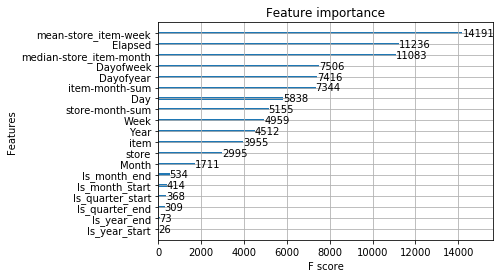

In [36]:
xgb.plot_importance(xgb_native_full_data)
plt.show()